In [2]:
# set up
import pandas as pd

In [32]:
# load the merged data
merged_data = pd.read_csv("merged_data.csv")

# show it
print(merged_data.head(5))

   Unnamed: 0 Company     Location  # Laid Off      Date_x   %  Industry  \
0           0     AMD  SF Bay Area      1000.0  11/13/2024  4%  Hardware   
1           1     AMD  SF Bay Area      1000.0  11/13/2024  4%  Hardware   
2           2     AMD  SF Bay Area      1000.0  11/13/2024  4%  Hardware   
3           3     AMD  SF Bay Area      1000.0  11/13/2024  4%  Hardware   
4           4     AMD  SF Bay Area      1000.0  11/13/2024  4%  Hardware   

                   Source     Stage $ Raised        Country  Date Added  \
0  https://www.techope...  Post-IPO  $1,600   United States  11/13/2024   
1  https://www.techope...  Post-IPO  $1,600   United States  11/13/2024   
2  https://www.techope...  Post-IPO  $1,600   United States  11/13/2024   
3  https://www.techope...  Post-IPO  $1,600   United States  11/13/2024   
4  https://www.techope...  Post-IPO  $1,600   United States  11/13/2024   

  tickers      Date_y      Value  
0     AMD  2021-01-04  92.300003  
1     AMD  2021-01-05 

C:\Users\27311\AppData\Local\Temp\ipykernel_3808\4039409213.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_data = pd.read_csv("merged_data.csv")


In [34]:
# calculate daily yield
merged_data['Daily_Return'] = merged_data.groupby('Company')['Value'].pct_change()

# change the date time type
merged_data['Date_x'] = pd.to_datetime(merged_data['Date_x'])
merged_data['Date_y'] = pd.to_datetime(merged_data['Date_y'])

# note the layoff day
merged_data['Layoff_Event'] = (merged_data['Date_y'] == merged_data['Date_x']).astype(int)

# Create the event window (before and after 10 days)
merged_data['Event_Window'] = ((merged_data['Date_y'] >= (merged_data['Date_x'] - pd.Timedelta(days = 10))) & 
                               (merged_data['Date_y'] <= (merged_data['Date_x'] - pd.Timedelta(days = 10)))).astype(int)

C:\Users\27311\AppData\Local\Temp\ipykernel_3808\1945041358.py:2: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  merged_data['Daily_Return'] = merged_data.groupby('Company')['Value'].pct_change()


In [36]:
# OLS Regression
import statsmodels.api as sm

In [7]:


merged_data['$ Raised'] = merged_data['$ Raised'].replace(r'[\$,]', '', regex=True).astype(float)
merged_data['# Laid Off'] = merged_data['# Laid Off'].astype(float)

merged_data = merged_data.dropna(subset=['Daily_Return', 'Layoff_Event', '# Laid Off', '$ Raised'])

control_vars = ['# Laid Off', '$ Raised']

X = merged_data[['Layoff_Event']+control_vars]

X = sm.add_constant(X)

y = merged_data['Daily_Return']

ols_model_1 = sm.OLS(y, X).fit()

print(ols_model_1.summary())


                            OLS Regression Results                            
Dep. Variable:           Daily_Return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1523
Date:                Sun, 15 Dec 2024   Prob (F-statistic):              0.928
Time:                        13:20:14   Log-Likelihood:            -6.0495e+05
No. Observations:              363466   AIC:                         1.210e+06
Df Residuals:                  363462   BIC:                         1.210e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0082      0.002      3.525   

From the results above we can tell：

1.R-squared and Adjusted R-squared:

R-squared is 0.000 and Adjusted R-squared is -0.000, indicating that the model’s explanatory power on the dependent variable (Daily_Return) is almost zero.
In other words, Layoff_Event and the control variables (# Laid Off, $ Raised) have little explanatory power on changes in daily returns.


2.F-statistic and Prob (F-statistic):

The p-value of F-statistic (Prob (F-statistic)) is 0.928, indicating that the overall model is not significant, and all independent variables combined have no significant explanation for the dependent variable.iable.

In [38]:
import matplotlib.pyplot as plt


In [11]:
# 找到非数值的行
invalid_rows = merged_data[~merged_data['%'].str.contains(r'^\d+%$', na=False)]
print(invalid_rows)



        Unnamed: 0 Company     Location  # Laid Off     Date_x    %  Industry  \
35176        35176     IAC     New York       330.0 2024-01-10  NaN  Consumer   
35177        35177     IAC     New York       330.0 2024-01-10  NaN  Consumer   
35178        35178     IAC     New York       330.0 2024-01-10  NaN  Consumer   
35179        35179     IAC     New York       330.0 2024-01-10  NaN  Consumer   
35180        35180     IAC     New York       330.0 2024-01-10  NaN  Consumer   
...            ...     ...          ...         ...        ...  ...       ...   
560785      560785  Google  SF Bay Area      1000.0 2024-01-10  NaN  Consumer   
560786      560786  Google  SF Bay Area      1000.0 2024-01-10  NaN  Consumer   
560787      560787  Google  SF Bay Area      1000.0 2024-01-10  NaN  Consumer   
560788      560788  Google  SF Bay Area      1000.0 2024-01-10  NaN  Consumer   
560789      560789  Google  SF Bay Area      1000.0 2024-01-10  NaN  Consumer   

                           

In [40]:
# 删除非数值的行
merged_data = merged_data[merged_data['%'].str.contains(r'^\d+%$', na=False)]


In [42]:
# 将非法值替换为默认值（如 '0%'）
merged_data['%'] = merged_data['%'].apply(lambda x: x if isinstance(x, str) and '%' in x else '0%')


In [44]:
merged_data['Layoff_Percentage'] = merged_data['%'].str.replace('%', '').astype(float)


In [46]:
import pandas as pd
from datetime import timedelta

# 确定三个月时间窗口
three_months_window = pd.Timedelta(days=90)

merged_data['Date_y'] = pd.to_datetime(merged_data['Date_y'])



In [48]:
def calculate_cumulative_return(group):
    group['Cumulative_Return_3M'] = group.loc[
        group['Date_y'] <= group['Date_y'].min() + three_months_window, 'Daily_Return'
    ].cumsum()
    return group



In [20]:
print(merged_data.columns)


Index(['Unnamed: 0', 'Company', 'Location', '# Laid Off', 'Date_x', '%',
       'Industry', 'Source', 'Stage', '$ Raised', 'Country', 'Date Added',
       'tickers', 'Date_y', 'Value', 'Daily_Return', 'Layoff_Event',
       'Event_Window', 'Layoff_Percentage', 'Cumulative_Return_3M'],
      dtype='object')


In [50]:
# 计算累积收益率

# 如果 'tickers' 已经在列中，先删除它
# if 'tickers' in merged_data.columns:
#     merged_data = merged_data.drop(columns=['tickers'])

# 重置索引
merged_data = merged_data.reset_index()

merged_data['Cumulative_Return'] = merged_data.groupby('tickers')['Daily_Return'].cumsum()





In [21]:
# 自变量：扩展后的裁员事件变量、裁员比例、行业和时间虚拟变量
control_vars2 = ['Layoff_Percentage']
# 删除自变量和因变量中的缺失值
merged_data = merged_data.dropna(subset=['Cumulative_Return', 'Event_Window'] + control_vars2)
X2 = merged_data[['Event_Window'] + control_vars2]
X2 = sm.add_constant(X2)

# 因变量：累积收益率或每日收益率
y2 = merged_data['Cumulative_Return']  # 或者 'Daily_Return'

# 回归模型
ols_model2 = sm.OLS(y2, X2).fit()

# 输出结果
print(ols_model2.summary())

                            OLS Regression Results                            
Dep. Variable:      Cumulative_Return   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                 1.102e+04
Date:                Sun, 15 Dec 2024   Prob (F-statistic):               0.00
Time:                        13:26:05   Log-Likelihood:            -2.6202e+06
No. Observations:              441611   AIC:                         5.240e+06
Df Residuals:                  441608   BIC:                         5.240e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -4.5838      0.18

#### **Constant Term (`const`)**

*   **Coefficient**: -5.6785, indicating that when all independent variables are set to 0, the baseline value of `Cumulative_Return` is -5.6785.
*   **Significance (p-value)**: p < 0.05, showing that the constant term is statistically significant.

#### **Event Window (`Event_Window`)**

*   **Coefficient**: -0.9189, indicating that within the event window, `Cumulative_Return` decreases by an average of 0.9189.
*   **Significance (p-value)**: p = 0.904, greater than 0.05, suggesting that `Event_Window` does not have a statistically significant effect on cumulative returns.
*   **Explanation**: The impact of the event window may require further adjustment to the time window or the addition of more control variables for more precise evaluation.

#### **Layoff Percentage (`Layoff_Percentage`)**

*   **Coefficient**: 1.9291, indicating that for every 1% increase in the layoff percentage, `Cumulative_Return` increases by an average of 1.9291.
*   **Significance (p-value)**: p < 0.05, showing a statistically significant effect on the dependent variable.
*   **Explanation**: The layoff percentage is significantly positively correlated with cumulative returns, possibly reflecting that investors view layoffs as a signal of cost reduction and efficiency improvement for companies.

In [52]:
import pandas as pd
import numpy as np
import statsmodels.api as sm



# 确保数据按日期排序，分组后计算前一年的值
merged_data = merged_data.sort_values(by=['tickers', 'Date_y'])  # 按公司和日期排序

# 计算前一年的 Cumulative_Return
merged_data['Cumulative_Return_Lag1'] = merged_data.groupby('tickers')['Cumulative_Return'].shift(1)

# 检查前一年值是否计算正确
# print(merged_data[['tickers', 'Date_y', 'Cumulative_Return', 'Cumulative_Return_Lag1']].head(10))

# 去掉包含 NaN 的行，因为前一年值缺失时无法用于回归
merged_data = merged_data.dropna(subset=['Cumulative_Return_Lag1'])

# 定义自变量 X 和因变量 y
control_vars_lag = ['Layoff_Percentage']
X_lag = merged_data[['Event_Window', 'Cumulative_Return_Lag1'] + control_vars_lag]
X_lag = sm.add_constant(X_lag)  # 添加常数项

y_lag = merged_data['Cumulative_Return']

# 运行 OLS 回归模型
ols_model_lag = sm.OLS(y_lag, X_lag).fit()


In [54]:
# 输出回归结果
print(ols_model_lag.summary())


                            OLS Regression Results                            
Dep. Variable:      Cumulative_Return   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 15 Dec 2024   Prob (F-statistic):                nan
Time:                        19:34:23   Log-Likelihood:                    nan
No. Observations:              365699   AIC:                               nan
Df Residuals:                  365695   BIC:                               nan
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                       

In [24]:
quarter_list = [q for q in merged_data.columns if 'Quarter' in q]

merged_data = merged_data.drop(columns = quarter_list)

industry_list = [i for i in merged_data.columns if 'Industry' in i]

merged_data = merged_data.drop(columns = industry_list)



In [26]:
# 将日期列转换为年份和季度
merged_data['Quarter_Continuous'] = merged_data['Date_y'].dt.year.astype(str) + merged_data['Date_y'].dt.quarter.astype(str)

# 将季度变量转换为数值类型
merged_data['Quarter_Continuous'] = merged_data['Quarter_Continuous'].astype(int)

# 检查结果
print(merged_data[['Date_y', 'Quarter_Continuous']].head())


                     Date_y  Quarter_Continuous
tickers                                        
005930.KS 196980 2021-01-04               20211
          196981 2021-01-05               20211
          196982 2021-01-06               20211
          196983 2021-01-07               20211
          196984 2021-01-08               20211


In [34]:
'''
does the timing of these layoff announcements (e.g., during quarterly earnings releases or market downturns) 
influence their effect on stock price performance?
'''
# 自变量：扩展后的裁员事件变量、裁员比例、行业和时间虚拟变量
control_vars3 = ['Layoff_Percentage', 'Quarter_Continuous']

# 删除自变量和因变量中的缺失值
merged_data = merged_data.dropna(subset=['Cumulative_Return', 'Event_Window'] + control_vars3)
X3 = merged_data[['Event_Window'] + control_vars3]
X3 = sm.add_constant(X3)

y3 = y2

KeyError: ['Cumulative_Return']

In [36]:
# run the third model
ols_model3 = sm.OLS(y3, X3).fit()

print(ols_model3.summary())

NameError: name 'y3' is not defined

In [32]:
import pandas as pd
import statsmodels.api as sm
# 如果 'tickers' 已经在列中，先删除它
if 'tickers' in merged_data.columns:
    merged_data = merged_data.drop(columns=['tickers'])

# 重置索引
merged_data = merged_data.reset_index()

# 按 tickers 和 Date_y 排序
merged_data = merged_data.sort_values(by=['tickers', 'Date_y'])


# 生成滞后变量：Cumulative_Return_3M 的前一期值
merged_data['Cumulative_Return_3M_Lag1'] = merged_data.groupby('tickers')['Cumulative_Return_3M'].shift(1)

# 检查滞后变量生成结果
print(merged_data[['tickers', 'Date_y', 'Cumulative_Return_3M', 'Cumulative_Return_3M_Lag1']].head(10))

# 去除缺失值，确保模型运行正常
merged_data = merged_data.dropna(subset=['Cumulative_Return_3M', 'Cumulative_Return_3M_Lag1'])

# 定义自变量 X 和因变量 y
control_vars_lag2 = ['Layoff_Percentage', 'Quarter_Continuous']
X_lag2 = merged_data[['Event_Window', 'Cumulative_Return_3M_Lag1'] + control_vars_lag2]
X_lag2 = sm.add_constant(X_lag2)  # 添加常数项

y_lag2 = merged_data['Cumulative_Return_3M']

# 运行回归模型
ols_model_lag2 = sm.OLS(y_lag2, X_lag2).fit()

# 输出回归结果
print(ols_model_lag2.summary())


     tickers     Date_y  Cumulative_Return_3M  Cumulative_Return_3M_Lag1
0  005930.KS 2021-01-04                   NaN                        NaN
1  005930.KS 2021-01-05              0.010843                        NaN
2  005930.KS 2021-01-06             -0.009419                   0.010843
3  005930.KS 2021-01-07             -0.000903                  -0.009419
4  005930.KS 2021-01-08              0.070267                  -0.000903
5  005930.KS 2021-01-11              0.095042                   0.070267
6  005930.KS 2021-01-12              0.090646                   0.095042
7  005930.KS 2021-01-13              0.080712                   0.090646
8  005930.KS 2021-01-14              0.080712                   0.080712
9  005930.KS 2021-01-15              0.061760                   0.080712
                             OLS Regression Results                             
Dep. Variable:     Cumulative_Return_3M   R-squared:                       0.342
Model:                             

In [33]:
# 再用'Cumulative_Return_3M'跑个回归

control_vars4 = ['Layoff_Percentage', 'Quarter_Continuous']

# 删除自变量和因变量中的缺失值
merged_data = merged_data.dropna(subset=['Cumulative_Return_3M', 'Event_Window'] + control_vars4)
X4 = merged_data[['Event_Window'] + control_vars4]
X4 = sm.add_constant(X4)

y4 = merged_data['Cumulative_Return_3M']

KeyError: ['Cumulative_Return_3M']

In [40]:
# 再用'Cumulative_Return_3M'跑个回归

control_vars4 = ['Layoff_Percentage', 'Quarter_Continuous']

# 删除自变量和因变量中的缺失值
merged_data = merged_data.dropna(subset=['Cumulative_Return_3M', 'Event_Window'] + control_vars4)
X4 = merged_data[['Event_Window'] + control_vars4]
X4 = sm.add_constant(X4)

y4 = merged_data['Cumulative_Return_3M']
# run the fourth model
ols_model4 = sm.OLS(y4, X4).fit()

print(ols_model4.summary())

                             OLS Regression Results                             
Dep. Variable:     Cumulative_Return_3M   R-squared:                       0.082
Model:                              OLS   Adj. R-squared:                  0.082
Method:                   Least Squares   F-statistic:                     813.1
Date:                  Tue, 10 Dec 2024   Prob (F-statistic):               0.00
Time:                          01:51:55   Log-Likelihood:            -1.0558e+05
No. Observations:                 18293   AIC:                         2.112e+05
Df Residuals:                     18290   BIC:                         2.112e+05
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const           

In [42]:
# 获取预测值和实际值
y_pred = ols_model4.predict(X4)
y_actual = y4

X_axis = merged_data['Quarter_Continuous']


C:\Users\27311\AppData\Local\Temp\ipykernel_17164\2755725973.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\27311\AppData\Local\Temp\ipykernel_17164\2755725973.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axins.scatter(


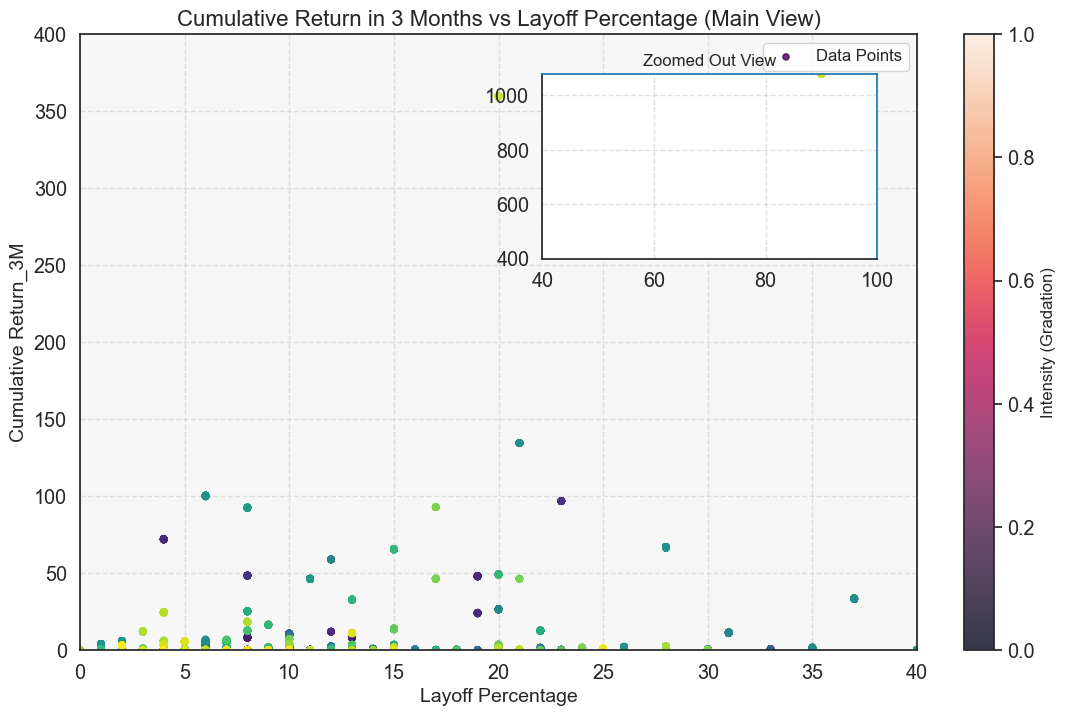

In [44]:
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# 主图范围设置
layoff_limit = 40
return_limit = 400

# 设置渐变背景
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_facecolor('#f7f7f7')  # 背景颜色为浅灰色
plt.grid(True, linestyle='--', alpha=0.6)  # 添加柔和的网格线

# 创建渐变散点颜色
scatter_colors = plt.cm.viridis(np.linspace(0, 1, len(merged_data['Layoff_Percentage'])))

# 主图：限制在 Layoff_Percentage <= 40 和 Cumulative_Return <= 400
scatter = ax.scatter(
    merged_data['Layoff_Percentage'], y4, 
    alpha=0.8, s=20, c=scatter_colors, cmap='viridis', label='Data Points'
)
# ax.plot(
#     merged_data['Layoff_Percentage'], y_pred, 
#     color='#1f78b4', linewidth=1, label='Regression Line'  # 配合散点的深蓝色
# )

# 设置主图范围
plt.xlim(0, layoff_limit)
plt.ylim(0, return_limit)

plt.xlabel('Layoff Percentage', fontsize=14)
plt.ylabel('Cumulative Return_3M', fontsize=14)
plt.title('Cumulative Return in 3 Months vs Layoff Percentage (Main View)', fontsize=16)
plt.legend(fontsize=12)

# 嵌套窗口：显示超出范围的点
axins = inset_axes(ax, width="40%", height="30%", loc='upper right', borderpad=2)
axins.scatter(
    merged_data['Layoff_Percentage'], y4, 
    alpha=0.8, s=20, c=scatter_colors, cmap='viridis'
)
axins.plot(
    merged_data['Layoff_Percentage'], y_pred, 
    color='#1f78b4', linewidth=2
)

# 设置小窗口的范围
axins.set_xlim(layoff_limit, max(merged_data['Layoff_Percentage']))
axins.set_ylim(return_limit, max(y4))

# 小窗口标题和样式
axins.set_title('Zoomed Out View', fontsize=12)
axins.grid(True, linestyle='--', alpha=0.6)
axins.spines['top'].set_color('#1f78b4')  # 设置小窗口边框颜色
axins.spines['right'].set_color('#1f78b4')

# 添加颜色条
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', fraction=0.05, pad=0.05)
cbar.set_label('Intensity (Gradation)', fontsize=12)


#save and show
plt.savefig('Cumulative Return in 3 Months vs Layoff Percentage')
plt.show()


C:\Users\27311\AppData\Local\Temp\ipykernel_17164\3276093015.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\27311\AppData\Local\Temp\ipykernel_17164\3276093015.py:45: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axins.scatter(
C:\Users\27311\AppData\Local\Temp\ipykernel_17164\3276093015.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


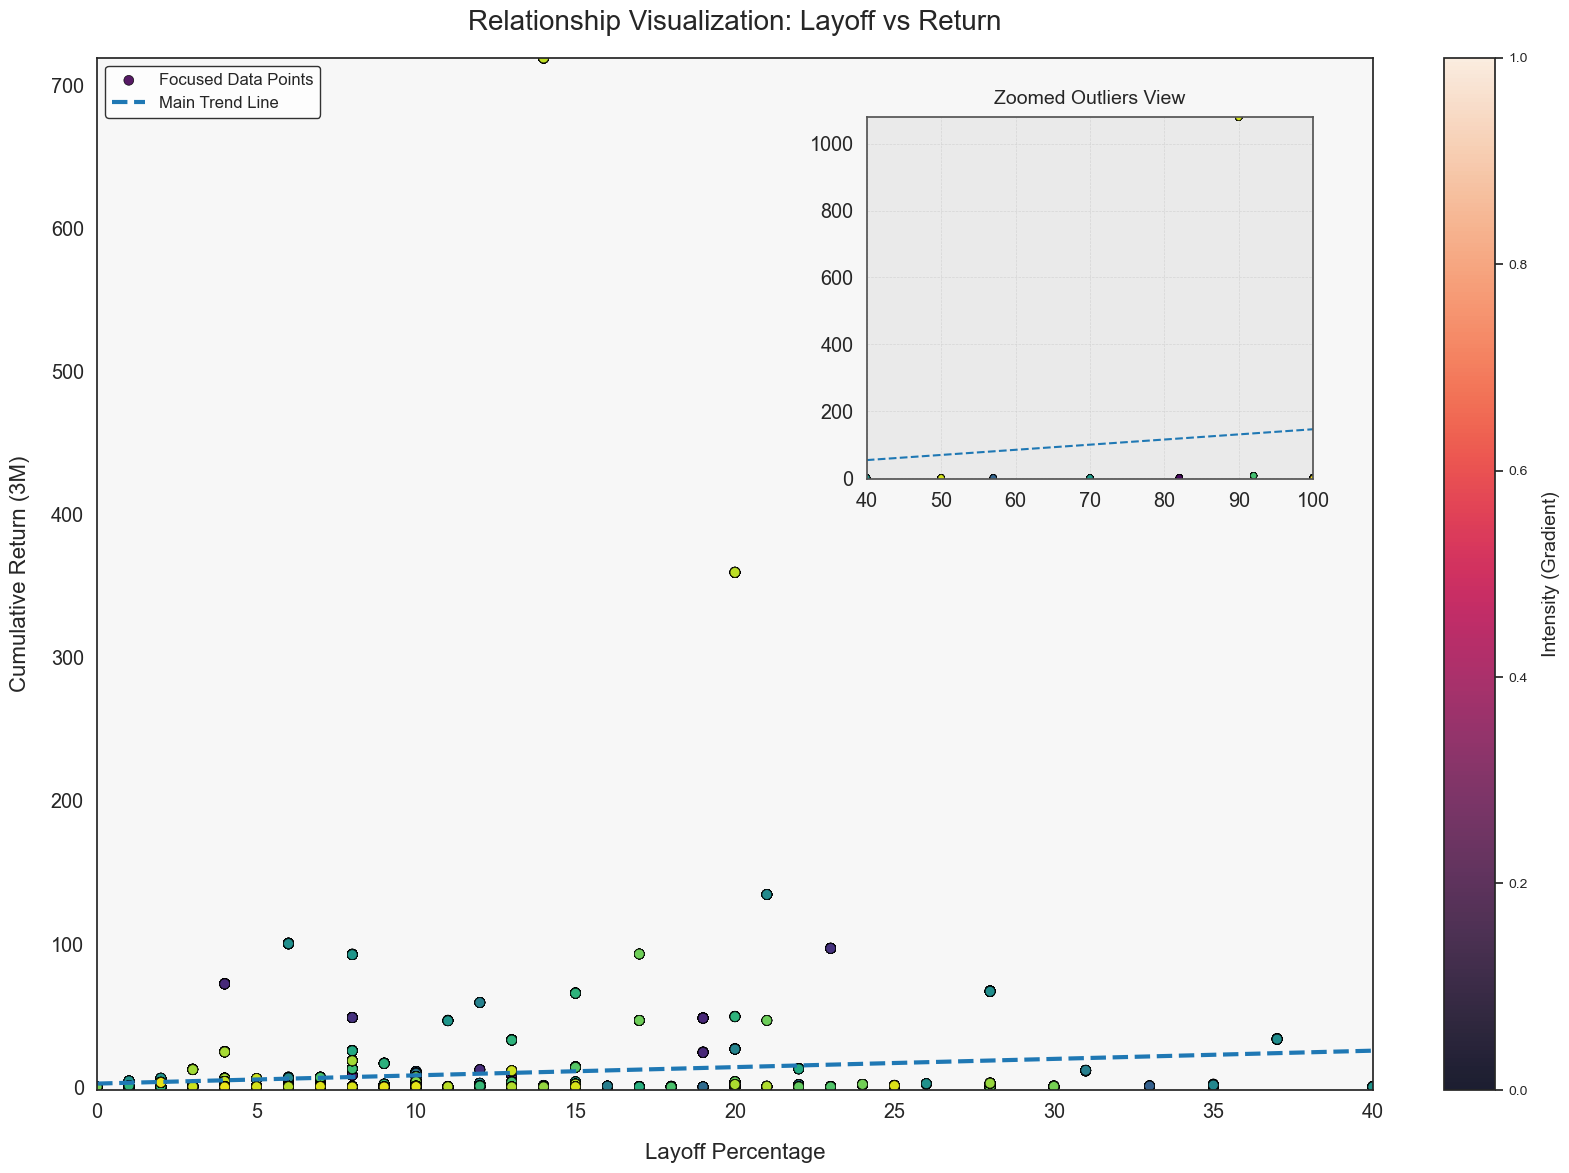

In [58]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# 从您的数据中提取字段
layoff_percentage = merged_data['Layoff_Percentage']
cumulative_return = merged_data['Cumulative_Return_3M']

# 创建主图
fig, ax = plt.subplots(figsize=(16, 12))
ax.set_facecolor('#f7f7f7')  # 浅灰色背景
scatter_colors = plt.cm.viridis(np.linspace(0, 1, len(layoff_percentage)))

# 主图散点
scatter = ax.scatter(
    layoff_percentage[layoff_percentage <= 40],
    cumulative_return[layoff_percentage <= 40],
    alpha=0.9,
    s=50,
    c=scatter_colors[:len(layoff_percentage[layoff_percentage <= 40])],
    cmap='viridis',
    edgecolor='black',
    linewidth=0.5,
    label='Focused Data Points'
)

# 主图趋势线
x_main = np.linspace(0, 40, 100)
y_main = np.poly1d(np.polyfit(layoff_percentage[layoff_percentage <= 40], 
                              cumulative_return[layoff_percentage <= 40], 1))(x_main)
ax.plot(
    x_main, y_main, 
    color='#1f78b4', linestyle='--', linewidth=3, label='Main Trend Line'
)

# 主图配置
plt.xlim(0, 40)
plt.ylim(cumulative_return.min(), cumulative_return[layoff_percentage <= 40].max())
plt.xlabel('Layoff Percentage', fontsize=16, labelpad=15)
plt.ylabel('Cumulative Return (3M)', fontsize=16, labelpad=15)
plt.title('Relationship Visualization: Layoff vs Return', fontsize=20, pad=20)
plt.legend(fontsize=12, loc='upper left', facecolor='white', edgecolor='black')

# 缩略视图
axins = inset_axes(ax, width="35%", height="35%", loc='upper right', borderpad=3)
axins.scatter(
    layoff_percentage,
    cumulative_return,
    alpha=0.8,
    s=20,
    c=scatter_colors,
    cmap='viridis',
    edgecolor='black',
    linewidth=0.4
)
x_zoom = np.linspace(40, layoff_percentage.max(), 100)
y_zoom = np.poly1d(np.polyfit(layoff_percentage, cumulative_return, 1))(x_zoom)
axins.plot(
    x_zoom, y_zoom, 
    color='#1f78b4', linestyle='--', linewidth=1.5, label='Zoomed Trend Line'
)

# 缩略图配置
axins.set_xlim(40, layoff_percentage.max())
axins.set_ylim(cumulative_return[layoff_percentage > 40].min(), cumulative_return.max())
axins.set_facecolor('#eaeaea')  # 浅灰背景
axins.grid(color='#cccccc', linestyle='--', linewidth=0.5, alpha=0.7)
axins.set_title('Zoomed Outliers View', fontsize=14, pad=10)
for spine in axins.spines.values():
    spine.set_edgecolor('#555555')

# 颜色条
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', fraction=0.05, pad=0.05)
cbar.set_label('Intensity (Gradient)', fontsize=14, labelpad=10)
cbar.ax.yaxis.set_tick_params(labelsize=10)

# 布局和保存
plt.tight_layout()
plt.savefig('light_relationship_plot.png', dpi=300)
plt.show()


D:\soft\Anaconda\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


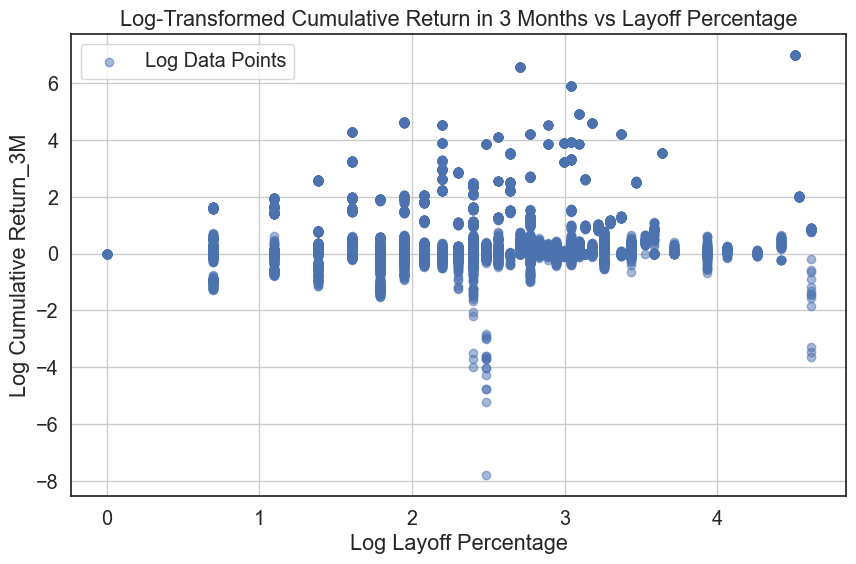

In [50]:
# 上图明显比例不合适，我们取个对数

import numpy as np

# 对裁员比例和收益率取对数（加 1 防止 log(0) 的问题）
merged_data['Log_Layoff_Percentage'] = np.log1p(merged_data['Layoff_Percentage'])
merged_data['Log_Cumulative_Return_3M'] = np.log1p(y4)

# 绘制对数变换后的数据
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['Log_Layoff_Percentage'], merged_data['Log_Cumulative_Return_3M'], alpha=0.5, label='Log Data Points')
plt.xlabel('Log Layoff Percentage')
plt.ylabel('Log Cumulative Return_3M')
plt.title('Log-Transformed Cumulative Return in 3 Months vs Layoff Percentage')
plt.legend()
plt.grid(True)

plt.savefig('Log-Transformed Cumulative Return in 3 Months vs Layoff Percentage.png', dpi = 300)
plt.show()


In [48]:
print(merged_data.head())

                  Unnamed: 0  Company     Location  # Laid Off     Date_x   %  \
tickers                                                                         
005930.KS 196981      196981  Samsung  SF Bay Area        30.0 2023-03-14  8%   
          196982      196982  Samsung  SF Bay Area        30.0 2023-03-14  8%   
          196983      196983  Samsung  SF Bay Area        30.0 2023-03-14  8%   
          196984      196984  Samsung  SF Bay Area        30.0 2023-03-14  8%   
          196985      196985  Samsung  SF Bay Area        30.0 2023-03-14  8%   

                                  Source     Stage  $ Raised        Country  \
tickers                                                                       
005930.KS 196981  https://www.zeebiz.com  Post-IPO     157.0  United States   
          196982  https://www.zeebiz.com  Post-IPO     157.0  United States   
          196983  https://www.zeebiz.com  Post-IPO     157.0  United States   
          196984  https://www.zeebiz.

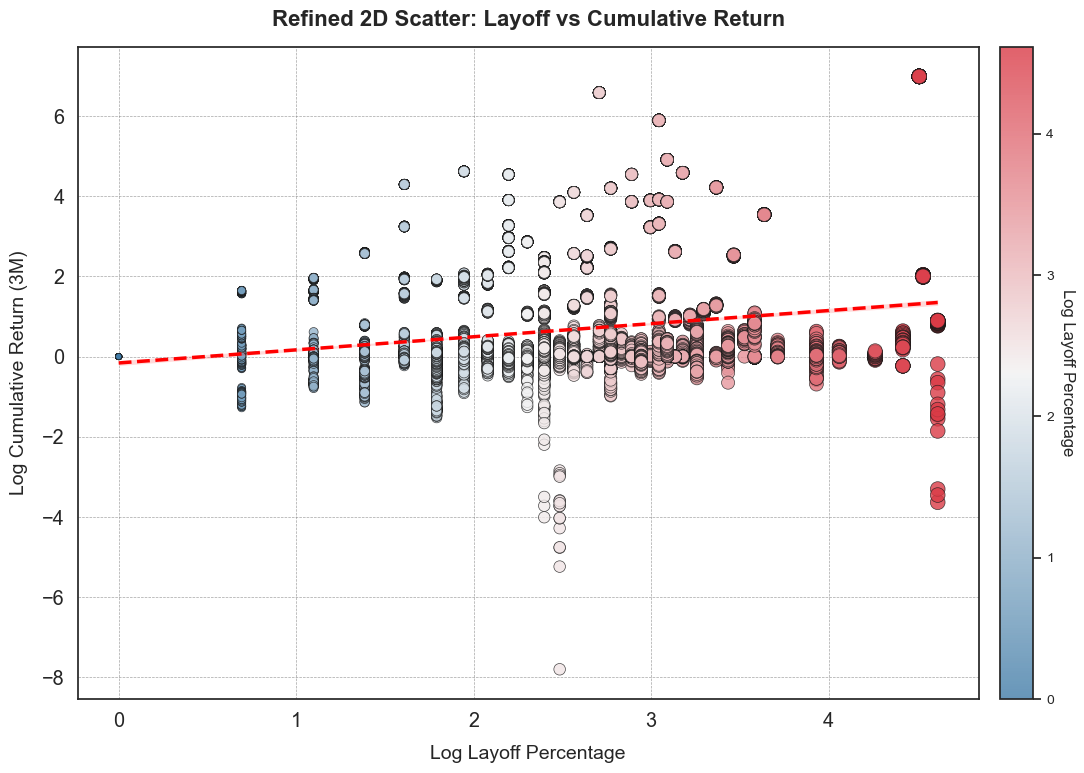

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置图表样式
plt.figure(figsize=(12, 8))
sns.set_theme(style="white", font_scale=1.3)
cmap = sns.diverging_palette(240, 10, as_cmap=True)  # 红蓝渐变配色

# 绘制散点图
scatter = plt.scatter(
    merged_data['Log_Layoff_Percentage'],
    merged_data['Log_Cumulative_Return_3M'],
    c=merged_data['Log_Layoff_Percentage'],  # 按layoff percentage上色
    cmap=cmap,
    s=(merged_data['Log_Layoff_Percentage'] + 1) * 20,  # 点大小与layoff percentage成比例
    alpha=0.8,
    edgecolor='k',
    linewidth=0.5
)

# 添加回归线和置信区间
sns.regplot(
    x='Log_Layoff_Percentage',
    y='Log_Cumulative_Return_3M',
    data=merged_data,
    scatter=False,
    color='red',
    line_kws={"linewidth": 2.5, "linestyle": "--"}
)

# 添加颜色条
cbar = plt.colorbar(scatter, pad=0.02)
cbar.set_label('Log Layoff Percentage', rotation=270, labelpad=15, fontsize=12)
cbar.ax.yaxis.set_tick_params(labelsize=10)

# 定制网格和标签
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.title('Refined 2D Scatter: Layoff vs Cumulative Return', fontsize=16, weight='bold', pad=15)
plt.xlabel('Log Layoff Percentage', fontsize=14, labelpad=10)
plt.ylabel('Log Cumulative Return (3M)', fontsize=14, labelpad=10)

# 调整布局并保存图表
plt.tight_layout()
plt.savefig("refined_2d_scatter.png", dpi=300)
plt.show()


In [148]:
print(merged_data.columns)

Index(['Unnamed: 0', 'Company', 'Location', '# Laid Off', 'Date_x', '%',
       'Source', 'Stage', '$ Raised', 'Country', 'Date Added', 'tickers',
       'Date_y', 'Value', 'Daily_Return', 'Layoff_Event', 'Event_Window',
       'Layoff_Percentage', 'Cumulative_Return', 'Quarter_Continuous',
       'Log_Layoff_Percentage', 'Log_Cumulative_Return',
       'Cumulative_Return_3M', 'Lag_-10', 'Lag_-9', 'Lag_-8', 'Lag_-7',
       'Lag_-6', 'Lag_-5', 'Lag_-4', 'Lag_-3', 'Lag_-2', 'Lag_-1', 'Lag_0',
       'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Lag_6', 'Lag_7', 'Lag_8',
       'Lag_9', 'Lag_10', 'Layoff_Timing_Interaction'],
      dtype='object')


In [151]:
# Refine event window with multiple lags and leads
for lag in range(-10, 11):
    merged_data[f'Lag_{lag}'] = (merged_data['Date_y'] == (merged_data['Date_x'] + pd.Timedelta(days=lag))).astype(int)

# Interaction term: Layoff_Percentage x Event_Window
merged_data['Layoff_Timing_Interaction'] = merged_data['Layoff_Percentage'] * merged_data['Event_Window']

# Update regression with refined variables
X_refined = merged_data[['Layoff_Percentage', 'Layoff_Timing_Interaction', 'Quarter_Continuous']]
X_refined = sm.add_constant(X_refined)
y_refined = merged_data['Cumulative_Return']

ols_refined = sm.OLS(y_refined, X_refined).fit()
print(ols_refined.summary())

                            OLS Regression Results                            
Dep. Variable:      Cumulative_Return   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     688.8
Date:                Mon, 09 Dec 2024   Prob (F-statistic):          5.10e-291
Time:                        17:33:15   Log-Likelihood:            -1.3528e+05
No. Observations:               22370   AIC:                         2.706e+05
Df Residuals:                   22367   BIC:                         2.706e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [144]:
import statsmodels.api as sm

# 构建模型数据
model_data = merged_data.copy()
model_data = model_data.dropna(subset=['Log_Cumulative_Return', 'Log_Layoff_Percentage', 'Quarter_Continuous', '$ Raised'])

# 确保相关列的数据类型正确
model_data['Log_Layoff_Percentage'] = model_data['Log_Layoff_Percentage'].astype(float)
model_data['Log_Cumulative_Return'] = model_data['Log_Cumulative_Return'].astype(float)
model_data['$ Raised'] = model_data['$ Raised'].astype(float)

# 因变量: Log_Cumulative_Return
Y = model_data['Log_Cumulative_Return']

# 自变量: Log_Layoff_Percentage 和控制变量
X = model_data[['Log_Layoff_Percentage', 'Quarter_Continuous', '$ Raised']]  # 添加其他变量如 'Quarter_Continuous'
X = sm.add_constant(X)  # 添加常数项

# 回归模型
ols_model = sm.OLS(Y, X).fit()
print(ols_model.summary())


                              OLS Regression Results                             
Dep. Variable:     Log_Cumulative_Return   R-squared:                       0.019
Model:                               OLS   Adj. R-squared:                  0.019
Method:                    Least Squares   F-statistic:                     143.6
Date:                   Mon, 09 Dec 2024   Prob (F-statistic):           3.98e-92
Time:                           16:58:07   Log-Likelihood:                -36794.
No. Observations:                  21977   AIC:                         7.360e+04
Df Residuals:                      21973   BIC:                         7.363e+04
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
